<a href="https://colab.research.google.com/github/ayushs0911/Image-Segmentation/blob/main/Image_Segmentation_using_U_Net_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kumaresanmanickavelu/lyft-udacity-challenge

In [ ]:
!unzip lyft-udacity-challenge.zip -d dataset

In [3]:
IMG_SHAPE = [192, 256]
BUFFER_SIZE = 1000
BATCH_SIZE = 32

INPUT_CHANNELS = 3


# Helper functions

In [4]:
def display_images(images, titles=None, plot_title=None, size=(15, 10), grayscale=False):
    """
    Display a list of images using matplotlib.pyplot.
    
    Parameters:
    images (list): A list of images to display.
    titles (list): A list of titles for each image in `images`.
    plot_title (str): A title for the whole plot.
    """
    
    if titles is None:
        titles = [f"Image {i + 1}" for i in range(len(images))]

    if plot_title is None:
        plot_title = "Images"

    fig, axs = plt.subplots(1, len(images), figsize=size)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img, cmap='gray' if grayscale else None)
        axs[i].axis('off')
        axs[i].set_title(title)
    
    fig.suptitle(plot_title if plot_title is not False else None, fontsize=20)
    plt.show()

In [5]:
def load_image(im_path):
  return cv2.cvtColor(cv2.imread(impath), cv2.COLORBGR2RGB)

In [6]:
def create_mask(pred):
    """
    Create a mask from a given prediction tensor.

    Parameters:
    pred (numpy.ndarray or tensorflow.Tensor): A 3D or 4D tensor of predictions.

    Returns:
    numpy.ndarray: A mask of the same shape as the input tensor.
    """
    mask = tf.argmax(pred, axis=-1)
    mask = np.array(mask[..., tf.newaxis])
    return mask

In [7]:
def get_predictions(model, images):
    """
    Generate masks for a list of input images using a deep learning model.

    Parameters:
    model (tensorflow.keras.Model): A deep learning model to use for prediction.
    images (list of str): A list of images to generate masks for.

    Returns:
    list of numpy.ndarray: A list of masks corresponding to the input images.
    """
    pred = model.predict(images)

    pred = [create_mask(p) for p in pred]

    return pred

In [8]:
folders = ['A', 'B', 'C', 'D', 'E']

In [9]:
image_folders = [f"/content/dataset/data{f}/data{f}/CameraRGB/" for f in folders]
mask_folders = [f"/content/dataset/data{f}/data{f}/CameraSeg/" for f in folders]

In [10]:
image_folders, mask_folders

(['/content/dataset/dataA/dataA/CameraRGB/',
  '/content/dataset/dataB/dataB/CameraRGB/',
  '/content/dataset/dataC/dataC/CameraRGB/',
  '/content/dataset/dataD/dataD/CameraRGB/',
  '/content/dataset/dataE/dataE/CameraRGB/'],
 ['/content/dataset/dataA/dataA/CameraSeg/',
  '/content/dataset/dataB/dataB/CameraSeg/',
  '/content/dataset/dataC/dataC/CameraSeg/',
  '/content/dataset/dataD/dataD/CameraSeg/',
  '/content/dataset/dataE/dataE/CameraSeg/'])

In [11]:
all_images = [os.path.join(folder, image) for folder in image_folders for image in os.listdir(folder)]
all_masks =  [os.path.join(folder, image) for folder in mask_folders for image in os.listdir(folder)]

In [12]:
len(all_images), len(all_masks)

(5000, 5000)

(600, 800, 3)


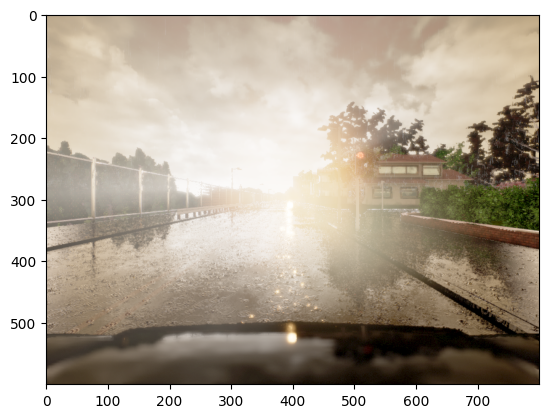

(600, 800, 3)


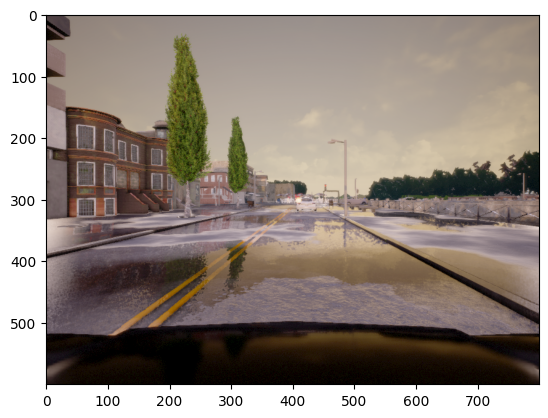

(600, 800, 3)


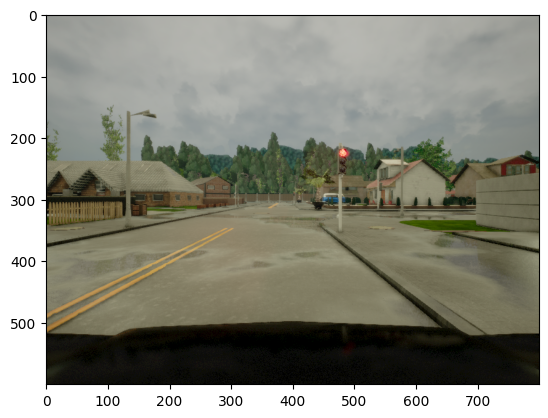

In [13]:
for images in random.sample(all_images, 3):
  print(plt.imread(images).shape)
  plt.imshow(plt.imread(images))
  plt.show()


In [14]:
for images in random.sample(all_masks, 3):
  print(plt.imread(images).shape)


(600, 800, 3)
(600, 800, 3)
(600, 800, 3)


Mask shape is also same 

In [15]:
image_list_ds = tf.data.Dataset.list_files(all_images, shuffle = False)
mask_list_ds = tf.data.Dataset.list_files(all_masks, shuffle = False)


In [16]:
full_ds = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

In [17]:
for i, m in full_ds.take(2):
  print(i)
  print(m)

tf.Tensor(b'/content/dataset/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataset/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataset/dataA/dataA/CameraRGB/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'/content/dataset/dataA/dataA/CameraSeg/02_00_001.png', shape=(), dtype=string)


# Process the data

In [18]:
def preprocess(image, mask):
  input_image = tf.image.resize(image, IMG_SHAPE, method = 'nearest')
  input_mask = tf.image.resize(mask, IMG_SHAPE, method = 'nearest')

  return input_image, input_mask

def process_path(image_path, mask_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels = 3)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims = True) #mask class is determined 

  img, mask = preprocess(img, mask,)

  return img, mask

In [19]:
image_ds = full_ds.map(process_path)

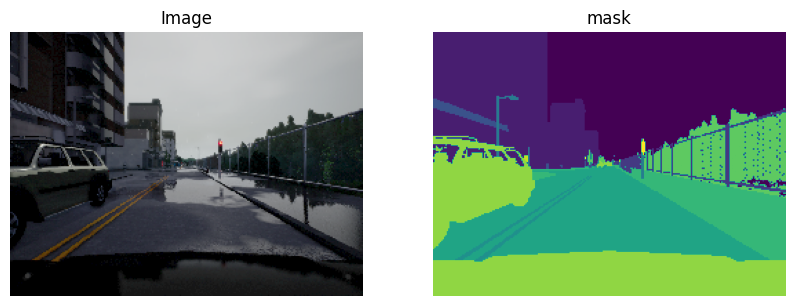

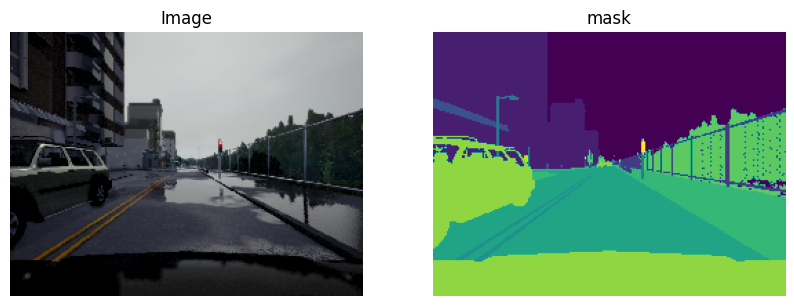

In [20]:
for image, mask in image_ds.take(2):
  display_images([image, mask], titles = ["Image", "mask"], plot_title = False, size = (10,10))

# Determine number of classes 

In [21]:
uniques = set()

for img, mask in image_ds.take(5000):
  uniques.update(np.unique(mask.numpy()))

print(uniques)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [22]:
OUTPUT_CHANNELS = len(uniques)
OUTPUT_CHANNELS

13

# Split into train, val, test

In [23]:
train_size = .7
val_size = .2
test_size = .1

ds_size = tf.data.experimental.cardinality(image_ds).numpy()

train_size = int(ds_size * train_size)
val_size = int(ds_size * val_size)
test_size = int(ds_size * test_size)

print("""Train size: {}
Val size: {}
Test size: {}""".format(train_size, val_size, test_size))

Train size: 3500
Val size: 1000
Test size: 500


In [24]:
image_ds = image_ds.shuffle(BUFFER_SIZE)

train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size).skip(val_size)

print("""Train size: {}
Val size: {}
Test size: {}""".format(tf.data.experimental.cardinality(train_ds).numpy(), 
                        tf.data.experimental.cardinality(val_ds).numpy(), 
                        tf.data.experimental.cardinality(test_ds).numpy()))

Train size: 3500
Val size: 1000
Test size: 500


# Model

In [29]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D()(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [30]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [31]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [32]:
img_height = 192
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [33]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
EPOCHS = 5

BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = val_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

model_history = unet.fit(train_dataset,
                         validation_data = validation_dataset,
                         epochs=EPOCHS)

Epoch 1/5
110/110 [==============================] - 269s 2s/step - loss: 1.2812 - accuracy: 0.6082 - val_loss: 0.5529 - val_accuracy: 0.8346
Epoch 2/5
110/110 [==============================] - 77s 698ms/step - loss: 0.4311 - accuracy: 0.8686 - val_loss: 0.3560 - val_accuracy: 0.8902
Epoch 3/5
110/110 [==============================] - 82s 744ms/step - loss: 0.2791 - accuracy: 0.9138 - val_loss: 0.2582 - val_accuracy: 0.9201
Epoch 4/5
110/110 [==============================] - 77s 697ms/step - loss: 0.2131 - accuracy: 0.9326 - val_loss: 0.2121 - val_accuracy: 0.9330
Epoch 5/5
110/110 [==============================] - 77s 697ms/step - loss: 0.1840 - accuracy: 0.9419 - val_loss: 0.1627 - val_accuracy: 0.9491


In [39]:
unet.save("is.h5")

In [41]:
test_ds_b = test_ds.batch(4).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

unet.evaluate(test_ds_b)

125/125 [==============================] - 105s 25ms/step - loss: 0.1630 - accuracy: 0.9489


[0.16297513246536255, 0.9489311575889587]

In [88]:
images = []
true_masks = []

for im, mask in test_ds.take(5):
    images.append(im.numpy())
    true_masks.append(mask.numpy())
    
pred = get_predictions(unet, np.array(images))

1/1 [==============================] - 1s 1s/step


[array([[[0.57254905, 0.5137255 , 0.46274513],
         [0.5764706 , 0.5176471 , 0.4666667 ],
         [0.58431375, 0.5254902 , 0.4666667 ],
         ...,
         [0.56078434, 0.5019608 , 0.45098042],
         [0.56078434, 0.5019608 , 0.45098042],
         [0.5568628 , 0.49803925, 0.44705886]],
 
        [[0.5764706 , 0.5176471 , 0.4666667 ],
         [0.5764706 , 0.5176471 , 0.4666667 ],
         [0.5764706 , 0.52156866, 0.4666667 ],
         ...,
         [0.56078434, 0.5019608 , 0.45098042],
         [0.56078434, 0.5019608 , 0.45098042],
         [0.5568628 , 0.5019608 , 0.45098042]],
 
        [[0.57254905, 0.5137255 , 0.46274513],
         [0.5764706 , 0.5176471 , 0.4666667 ],
         [0.5764706 , 0.5176471 , 0.4666667 ],
         ...,
         [0.56078434, 0.5058824 , 0.45098042],
         [0.56078434, 0.5019608 , 0.45098042],
         [0.5568628 , 0.5019608 , 0.44705886]],
 
        ...,
 
        [[0.16470589, 0.10980393, 0.10980393],
         [0.18039216, 0.13333334, 0.10980

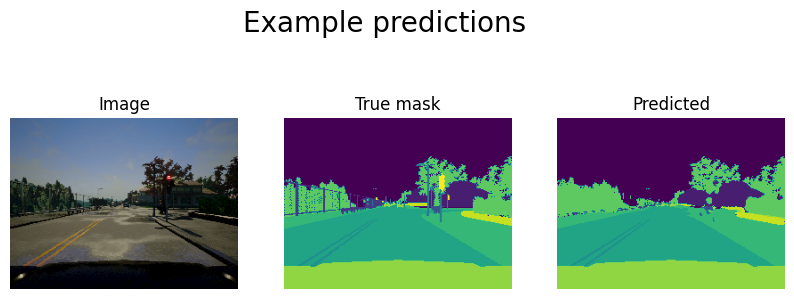

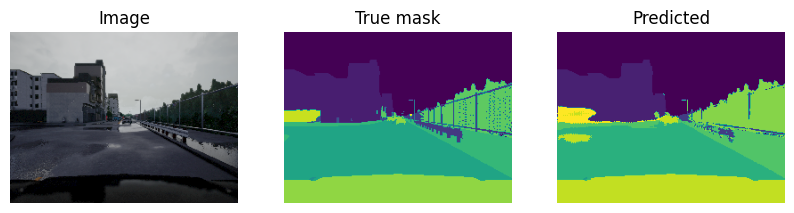

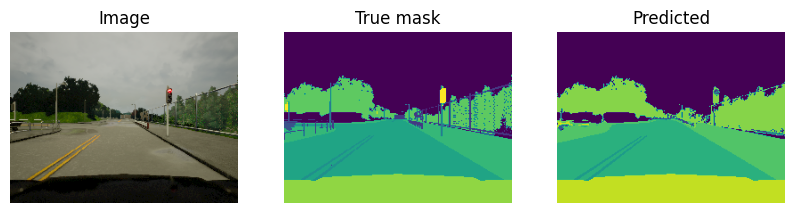

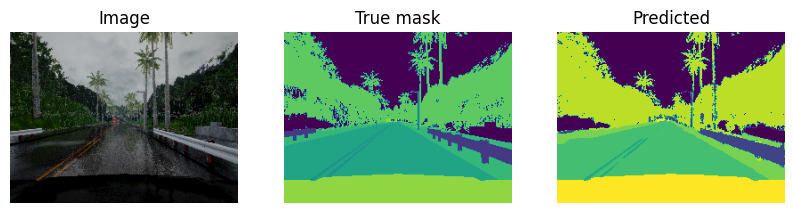

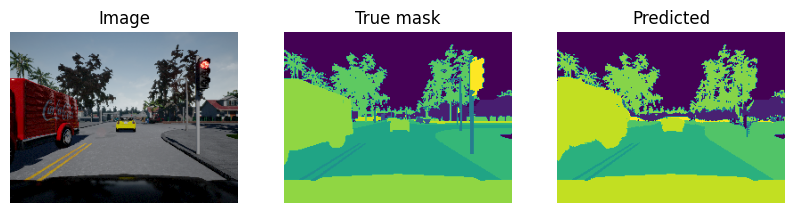

In [44]:
first = True

for im, true, pred in zip(images, true_masks, pred):
    display_images([im, true, pred], size=(10, 4), plot_title="Example predictions" if first else False, titles=("Image", "True mask", "Predicted"))
    first = False

Possible use case<br>
In reality, if you're planning to train the model on an another dataset, the dataset will probably have a different amount of classes to predict. This means that our last layer is now unfit for the job. So, let's replace it with some other last layer:
```
OUTPUT_CHANNELS = 40

new_last = Conv2D(OUTPUT_CHANNELS, 1, strides=1, padding='same')(loaded_model.layers[-2].output)
loaded_model = tf.keras.Model(inputs=loaded_model.inputs, outputs=new_last)

loaded_model.summary()
```
